[View in Colaboratory](https://colab.research.google.com/github/ckbjimmy/2018_mlw/blob/master/nb1_classification.ipynb)

# Machine Learning for Clinical Predictive Analytics

We would like to introduce the basic knowledge of machine learning and toolkits for clinical knowledge discovery in the workshop.
The material will cover common classification and clustering algorithms for clinical prediction tasks, as well as the diagnostic workflow of applying machine learning to real-world problems. 
We will use [Google colab](https://colab.research.google.com/) / python jupyter notebook and pre-extracted ICU data from PhysioNet database (MIMIC) to build predictive models.

- Learning objectives

  * Learn how to use Google colab / jupyter notebook
  * Learn how to build machine learning models for clinical classification and clustering tasks

- [Skillset] basic python syntax
- [Requirements] Google account OR [anaconda](https://anaconda.org/anaconda/python)

In part 1, we will go through the basic of modeling for classification.
In part 2, we will investigate more on clustering and visualizing the results.

In the first part of the workshop, we would like to explore how to utilize machine learning algorithms to approach clinical predictive analytic problems, epscifically, the classification problem.

The tutorial is modified from Alistair's version.

In the beginning, we will install and import the packages needed for the workshop (we usually do this in python). Then we will work on a well-structured breast cancer dataset, then move on to the real world MIMIC dataset.

In the first chunk, it will take few seconds to install and import packages.

In [17]:
try:
    import psycopg2
except:
    !pip install psycopg2
  
try:
    import pydotplus
except:
    !pip install pydotplus
    
try:
    import graphviz
except:
    !apt-get install graphviz -y


from __future__ import print_function

# Import libraries
import numpy as np
import pandas as pd
import sklearn
import psycopg2
import sys
import datetime as dt

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties # for unicode fonts

from collections import OrderedDict

from sklearn import datasets

# used to print out pretty pandas dataframes
from IPython.display import display, HTML

from sklearn.pipeline import Pipeline

# used to impute mean for data and standardize for computational stability
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV # l2 regularized regression
from sklearn.linear_model import LassoCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn import model_selection

# used to calculate AUROC/accuracy
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# used to create confusion matrix
from sklearn.metrics import confusion_matrix

%matplotlib inline

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


Here we defined the `plot_model_pred_2d` function for plotting. We will use this function later for visualizing the decision boundaries.

In [0]:
def plot_model_pred_2d(mdl, X, y, feat):
    # look at the regions in a 2d plot
    # based on scikit-learn tutorial plot_iris.html

    # get minimum and maximum values
    x0_min = X[:, 0].min()
    x0_max = X[:, 0].max()
    x1_min = X[:, 1].min()
    x1_max = X[:, 1].max()

    xx, yy = np.meshgrid(np.linspace(x0_min, x0_max, 100),
                         np.linspace(x1_min, x1_max, 100))

    Z = mdl.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the contour - colouring different regions
    cs = plt.contourf(xx, yy, Z, cmap='Blues')

    # plot the individual data points - colouring by the *true* outcome
    color = y.ravel()
    plt.scatter(X[:, 0], X[:, 1], c=color, marker='o', s=40, cmap='Blues')

    plt.xlabel(feat[0])
    plt.ylabel(feat[1])
    plt.axis("tight")
    plt.colorbar()

## Breast cancer prediction (classifying tumor or not)

Let's start from using the breast cancer dataset in UCI data repository to have a quick view on how to do the analysis and build models for well structured data without missing data and other problems. We load the breast cancer dataset from `sklearn.datasets`, and show the description of this dataset.

Here we just use the second and the last feature (mean texture and worst fractal dimension, `[1, 29]`) for modeling.

In [34]:
# real example
df_bc = datasets.load_breast_cancer()
print([k for k in df_bc.keys()])
print(df_bc['feature_names'])

# if you want a description of the dataset, uncomment the below line
print(df_bc['DESCR'])

# pick index of the features to use (only pick 2)
#    :Attribute Information (in order):
#        0 - CRIM     per capita crime rate by town
#        1 - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
#        2 - INDUS    proportion of non-retail business acres per town
#        3 - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#        4 - NOX      nitric oxides concentration (parts per 10 million)
#        5 - RM       average number of rooms per dwelling
#        6 - AGE      proportion of owner-occupied units built prior to 1940
#        7 - DIS      weighted distances to five Boston employment centres
#        8 - RAD      index of accessibility to radial highways
#        9 - TAX      full-value property-tax rate per $10,000
#       10 - PTRATIO  pupil-teacher ratio by town
#       11 - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#       12 - LSTAT    % lower status of the population
#       13 - MEDV     Median value of owner-occupied homes in $1000's

idx = [1, 29]
X = df_bc['data'][:, idx]
y = df_bc['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

feat = [x for x in df_bc['feature_names'][idx]]

['data', 'target', 'target_names', 'DESCR', 'feature_names']
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        

Above, we've extracted only two features out of the breast cancer dataset as predictors for tumor or not.
We use these to quickly visualize all the models we have presented here. 
In the figure, we can see the decision boundaries created by the models.
These boundaries can be a source of interpretability of the clinical predictive model.
We also print out their performance as measured by the Area Under the Receiver Operator Characteristic curve (AUROC), which is a commonly used metrics in machine learning world.

AUROC	Model
0.780	Logistic Regression
0.688	Decision Tree
0.807	Gradient Boosting
0.791	Random Forest
0.798	Bagging
0.801	AdaBoost


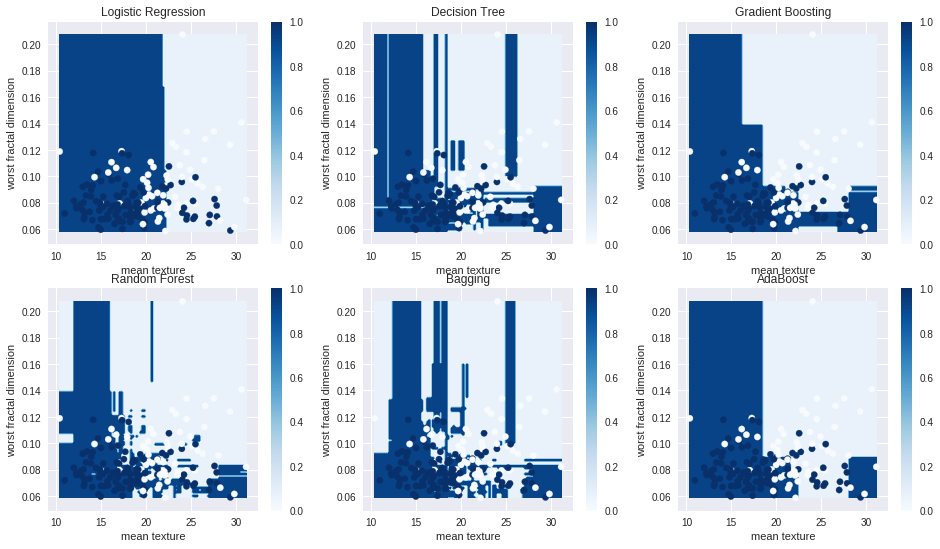

In [35]:
clf = dict()
clf['Logistic Regression'] = LogisticRegression(fit_intercept=True).fit(X_train,y_train)
clf['Decision Tree'] = DecisionTreeClassifier(criterion='entropy', splitter='best').fit(X_train,y_train)
clf['Gradient Boosting'] = GradientBoostingClassifier(n_estimators=10).fit(X_train, y_train)
clf['Random Forest'] = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
clf['Bagging'] = BaggingClassifier(n_estimators=10).fit(X_train, y_train)
clf['AdaBoost'] = AdaBoostClassifier(n_estimators=10).fit(X_train, y_train)

fig = plt.figure(figsize=[16,9])

print('AUROC\tModel')
for i, curr_mdl in enumerate(clf):
    yhat = clf[curr_mdl].predict_proba(X_test)[:,1]
    score = metrics.roc_auc_score(y_test, yhat)
    print('{:0.3f}\t{}'.format(score, curr_mdl))
    ax = fig.add_subplot(2,3,i+1)
    plot_model_pred_2d(clf[curr_mdl], X_test, y_test, feat)
    
    plt.title(curr_mdl)
    
plt.show()

Here we can see that quantitatively, Logistic Regression, AdaBoost and Gradient Boosting have produced the highest discrimination among all the models (~0.80). 
The decision surfaces of these models also seem simpler, and less "noisy", which is likely the reason for the improved **generalization** on the held out test set.

Now we will include all features of the breast cancer dataset - we will no longer be able to easily visualize the models, but we will be able to better evaluate them. 
We'll also switch to using **5-fold cross-validation** to get a good estimate of the generalization performance of the model.

In [36]:
X = df_bc['data']
y = df_bc['target']

# use cross-validation to estimate the performance of each model
print('Acc\tAUROC\tModel')
for curr_mdl in clf:
    scores = cross_val_score(clf[curr_mdl], X, y, cv=5, scoring='accuracy')
    auc = cross_val_score(clf[curr_mdl], X, y, cv=5, scoring='roc_auc')
    print('{:0.3f}\t{:0.3f}\t{}'.format(scores.mean(), auc.mean(), curr_mdl))

Acc	AUROC	Model
0.953	0.992	Logistic Regression
0.937	0.939	Decision Tree
0.944	0.981	Gradient Boosting
0.948	0.989	Random Forest
0.947	0.977	Bagging
0.946	0.988	AdaBoost


We can note two things here:

1. by **using the entire feature set** we have dramatically improved performance of the model, indicating that there was more information contained in the other columns, and
2. most of our models are performing relatively equivalently (except for the super simple model, the decision tree), and do not forget logistic regression!

## PhysioNet
We'll now practice using these models on a dataset acquired from patients admitted to intensive care units at the Beth Israel Deaconness Medical Center in Boston, MA. 
All patients in the cohort stayed for at least 48 hours, and the goal of the prediction task is to predict in-hospital mortality. 
If you're interested, you can read more about the dataset [here](http://physionet.org/challenge/2012/).

The data is originally provided as hourly observations for a number of variables, and the preprocessing step involved extracting summary statistics across all these observations.
The outcome is the first column `hospitalmortality`. 
The rest of the data are features you can use to predict this binary outcome.
We will again try to build the classifier using logistic regression.
You may want to use decision trees, AdaBoost, Random Forest, Bagging, and Gradient Boosting. 
Pick your favourite and play with the parameters to see how well you can do! 
Be sure to use cross-validation to make sure you don't overfit.

First, we start from loading the data and look at all columns in the dataset---there are 182 possible predictors and one outcome variable.

In [38]:
df = pd.read_csv('https://raw.githubusercontent.com/ckbjimmy/2018_mlw/master/data/PhysionetChallenge2012_data.csv')
df.head()

,hospitalmortality,ALPMin,ALPMax,ALPFirst,ALPLast,ALPMedian,ALTMin,ALTMax,ALTFirst,ALTLast,...,pHMax,pHFirst,pHLast,pHMedian,MechVentFirst,MechVentLast,MechVentMax,MechVentStartTime,MechVentDuration,TroponinMeasured
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.45,7.45,7.37,7.4,1.0,0.0,1.0,71.0,360.0,0.0
2,0.0,105.0,127.0,127.0,105.0,116.0,75.0,91.0,91.0,75.0,...,7.51,7.51,7.47,7.5,0.0,1.0,1.0,617.0,2160.0,0.0
3,0.0,105.0,105.0,105.0,105.0,105.0,12.0,12.0,12.0,12.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
print([x for x in df.columns])

183
['hospitalmortality', 'ALPMin', 'ALPMax', 'ALPFirst', 'ALPLast', 'ALPMedian', 'ALTMin', 'ALTMax', 'ALTFirst', 'ALTLast', 'ALTMedian', 'ASTMin', 'ASTMax', 'ASTFirst', 'ASTLast', 'ASTMedian', 'Age', 'AlbuminMin', 'AlbuminMax', 'AlbuminFirst', 'AlbuminLast', 'AlbuminMedian', 'BUNMin', 'BUNMax', 'BUNFirst', 'BUNLast', 'BUNMedian', 'BilirubinMin', 'BilirubinMax', 'BilirubinFirst', 'BilirubinLast', 'BilirubinMedian', 'CholesterolFirst', 'CholesterolLast', 'CreatinineMin', 'CreatinineMax', 'CreatinineFirst', 'CreatinineLast', 'CreatinineMedian', 'DiasABPMin', 'DiasABPMax', 'DiasABPFirst', 'DiasABPLast', 'DiasABPMedian', 'FiO2Min', 'FiO2Max', 'FiO2First', 'FiO2Last', 'FiO2Median', 'GCSMin', 'GCSMax', 'GCSFirst', 'GCSLast', 'GCSMedian', 'Gender', 'GlucoseMin', 'GlucoseMax', 'GlucoseFirst', 'GlucoseLast', 'GlucoseMedian', 'HCO3Min', 'HCO3Max', 'HCO3First', 'HCO3Last', 'HCO3Median', 'HCTMin', 'HCTMax', 'HCTFirst', 'HCTLast', 'HCTMedian', 'HRMin', 'HRMax', 'HRFirst', 'HRLast', 'HRMedian', 'Hei

Next, we want to split features and outcome variable.

In [0]:
# get X and y from the df

# first column [0] is target
y = df['hospitalmortality'].values

# second column onward [1:] are features 
X = df.drop(['hospitalmortality'], axis=1).values

# we keep the feature name in X_header
X_header = df.drop(['hospitalmortality'],axis=1).columns

In [56]:
# train a simple regression
mdl = LogisticRegression(fit_intercept=True).fit(X, y)

ValueError: ignored

The above statement Input contains NaN tells us that we have missing data! (Alistair: Dramatic music plays).

Good thing about Google colab---they have a button for you to search stackoverflow.

In [57]:
df.head().T

,0,1,2,3,4
hospitalmortality,0.0,0.00,0.00,0.0,0.0
ALPMin,NaN,NaN,105.00,105.0,NaN
ALPMax,NaN,NaN,127.00,105.0,NaN
ALPFirst,NaN,NaN,127.00,105.0,NaN
ALPLast,NaN,NaN,105.00,105.0,NaN
ALPMedian,NaN,NaN,116.00,105.0,NaN
ALTMin,NaN,NaN,75.00,12.0,NaN
ALTMax,NaN,NaN,91.00,12.0,NaN
ALTFirst,NaN,NaN,91.00,12.0,NaN
ALTLast,NaN,NaN,75.00,12.0,NaN


### Missing data imputation

In the above transposed view, we can see a few of the missing values for lactate, height, bmi, etc. There are many methods which can be used for missing data imputation. Of those tools, many of them are available in the imputer module of scikit-learn.

Here is a [brief tutorial of imputing missing values](http://scikit-learn.org/stable/modules/preprocessing.html#imputation).

You can [read more about the imputer module here](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html).

We choose to take a reasonably simple approach, and replace all missing values (`'NaN'`) with the mean value of observed measurements (`strategy='mean'`).

In [0]:
# define the method of imputation
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

# learn the parameters of that imputation using our data X
# i.e., in our case, calculate the means of each column which we will use to impute data
imp = imp.fit(X)

# apply that imputation
X_transform = imp.transform(X)

We can now see that our missing data has been replaced:

In [61]:
print('Before:', end='')
print(X[0:10, 0])

print('After:', end='')
print(X_transform[0:10, 3])

Before:[ nan  nan 105. 105.  nan 101.  nan  47.  nan  nan]
After:[104.30236686 104.30236686 105.         105.         104.30236686
 101.         104.30236686  47.         104.30236686 104.30236686]


For linear models (e.g. logistic regression), this will be roughly equivalent to imputing the average risk for this feature for patients missing that data.

We can now train a model on the data!

In [65]:
mdl = LogisticRegression(fit_intercept=True)
mdl.fit(X_transform, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We can evaluate the model using the AUROC. 
An AUROC = 0.5 represents a random classifier making random predictionds, while an AUROC = 1.0 represents a perfect classifier which always outputs the correct prediction.

In [66]:
yhat = mdl.predict_proba(X_transform)[:,1]
auc = metrics.roc_auc_score(y, yhat)

print('{:0.3f} - AUROC of model (training set).'.format( auc ))

0.877 - AUROC of model (training set).


### Find the important features

Let's dig into the model to determine what is driving the predictions. In healthcare applications, model interpretability is very important as it can be used to validate the model's construct validity.

In [68]:
# plot the coefficients
coef = np.row_stack([df.columns[1:], mdl.coef_]).T

idxSort = np.argsort(coef[:,1])

print('Top 5 predictors negatively correlated with mortality:')
for n in range(5):
    print('{:1.2f} - {}'.format(coef[idxSort[n],1], coef[idxSort[n],0]))
    
print()
print('Top 5 predictors positively correlated with mortality:')
for n in range(5):
    print('{:1.2f} - {}'.format(coef[idxSort[-n-1],1], coef[idxSort[-n-1],0]))

Top 5 predictors negatively correlated with mortality:
-0.35 - TempMedian
-0.34 - CSRU
-0.29 - BilirubinFirst
-0.24 - GCSLast
-0.21 - MechVentFirst

Top 5 predictors positively correlated with mortality:
0.42 - TroponinMeasured
0.26 - FiO2Last
0.25 - FiO2Median
0.22 - SICU
0.21 - MICU


One issue with these coefficients is that they are unadjusted---that is they are based on the original scale of the data. 
The coefficient for FiO2, shown in percentage (0-100), will likely be ~100 times higher than the coefficient for mechanical ventilation (0/1). 
While this is fine for modelling purposes, it also means we can't directly compare the magnitudes of the coefficients to determine the magnitude of the association between the feature and risk.

Of course there is a solution! 
We can scale the data using `StandardScaler` function in scikit-learn.

In [0]:
# problem: the above coefficients all operate on different scales
# solution: scale the data before we use it in the model
imp = Imputer(missing_values='NaN', strategy="mean", axis=0)
imp = imp.fit(X)
X_transform = imp.transform(X)

scale = StandardScaler()
scale = scale.fit(X_transform)
X_transform = scale.transform(X_transform)

In [0]:
# fit the model on scaled data
mdl = LogisticRegression(fit_intercept=True)
mdl = mdl.fit(X_transform, y)

In [74]:
# evaluate the model
yhat = mdl.predict_proba(X_transform)[:,1]
auc = metrics.roc_auc_score(y, yhat)

print('{:0.3f} - AUROC of model (training set).'.format( auc ))

0.881 - AUROC of model (training set).


In [75]:
# print the coefficients
coef = np.row_stack([df.columns[1:], mdl.coef_]).T
idxSort = np.argsort(coef[:,1])

print('Top 5 predictors negatively correlated with mortality:')
for n in range(5):
    print('{:1.2f} - {}'.format(coef[idxSort[n],1], coef[idxSort[n],0]))
    
print()
print('Top 5 predictors positively correlated with mortality:')
for n in range(5):
    print('{:1.2f} - {}'.format(coef[idxSort[-n-1],1], coef[idxSort[-n-1],0]))

Top 5 predictors negatively correlated with mortality:
-0.89 - ALPMax
-0.83 - GCSLast
-0.79 - pHMin
-0.71 - BilirubinFirst
-0.58 - ASTFirst

Top 5 predictors positively correlated with mortality:
0.73 - BilirubinMedian
0.69 - ASTMin
0.67 - MechVentDuration
0.64 - BUNLast
0.64 - pHMedian


Let's look at the odds ratios for these coefficients graphically. This will give us a more intuitive comparison between the features. For those which have negative correlation with bad outcome (i.e. higher values indicate better prognosis), we reverse the coefficient on the graph so it is more comparable.

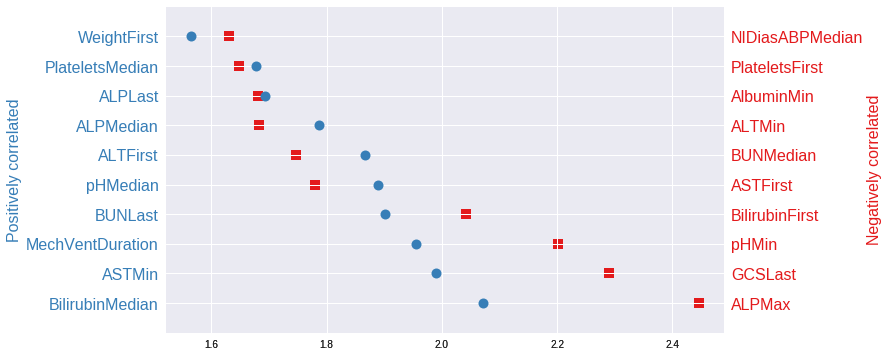

In [77]:
# plot the top 10 lowest / highest
coef = np.row_stack([df.columns[1:], mdl.coef_]).T
idxSort = np.argsort(coef[:,1])

idxTop = idxSort[0:10]
idxBot = idxSort[-1:-11:-1]

colTop = [0.8906,0.1016,0.1094]
colBot = [0.2148,0.4922,0.7188]

f = plt.figure(figsize=[10,6])
ax1 = f.add_subplot(111)
ax1.plot( np.exp(-coef[idxTop,1].astype(float)), range(10), 's', markersize=10, color = colTop)

# move negatively correlated ticklabels over to the right
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_ylim([-1,10])

ax1.yaxis.set_ticks(range(10))
ax1.yaxis.set_ticklabels(coef[idxTop,0], color=colTop, fontsize=16)
plt.ylabel("Negatively correlated", color=colTop, fontsize=16)

ax2 = f.add_subplot(111, sharex=ax1, frameon=False)
ax2.plot( np.exp(coef[idxBot,1].astype(float)), range(10), 'o', markersize=10, color=colBot )


ax2.yaxis.set_ticks(range(10))
ax2.yaxis.set_ticklabels(coef[idxBot,0], color=colBot, fontsize=16)
ax2.set_ylim([-1,10])
plt.ylabel("Positively correlated", color=colBot, fontsize=16)

# set axes
plt.show()

### Pipeline

We can use scikit-learn's pipeline feature to combine together all of these steps (imputation, scaling, and final model building). This is technically the same thing, but syntactically it's a lot cleaner!



In [78]:
# can use pipelines as a nicer way of doing the above
estimator = Pipeline([
        ("imputer", Imputer(missing_values='NaN',
                                  strategy="mean",
                                  axis=0)),
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(fit_intercept=True))
    ])

mdl_pipeline = estimator.fit(X, y)

yhat = mdl_pipeline.predict_proba(X)[:,1]

auc = metrics.roc_auc_score(y, yhat)
print('{:0.3f} - AUROC of model (training set).'.format( auc ))

0.881 - AUROC of model (training set).


Note that we achieve the same performance as before---again, this is simply a short form of what we have done before.

You'll note that the print statement keeps stating "training set", and may be wondering what this means and why it matters. 
The training set corresponds to the data used to develop the model.
Importantly, this means that the model has seen the data that we are using to estimate how well the model is doing. 
For the regression model above, the consequences of this may not be obvious. 
Let's switch to a more flexible model and see what happens.

In [79]:
# can use pipelines as a nicer way of doing the above
estimator = Pipeline([
        ("imputer", Imputer(missing_values='NaN',
                                  strategy="mean",
                                  axis=0)),
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier())
    ])

mdl_pipeline = estimator.fit(X, y)

yhat = mdl_pipeline.predict_proba(X)[:,1]

auc = metrics.roc_auc_score(y, yhat)
print('{:0.3f} - AUROC of model (training set).'.format( auc ))

1.000 - AUROC of model (training set).


Amazing! We have an AUROC = 1.0, which is perfect, therefore we have a perfect model. Time to go home!

Obviously, it's not that simple, though we wish it were :) We have used a model called a Random Forest. Omitting a few details, a random forest is a collection of decision trees. Each decision tree tries to perfectly classify a small subset of the overall data. When combined together, all of these decision trees perfectly classify the entire dataset. However, that does not mean that they work perfectly!

How can we check this? Well, let's hide some data from the classifier, and see how well it does on this hidden data. This is a very common concept in machine learning: we have a training set, and we hide a test set to see how we're really doing.

### Prevent from overfitting

In [0]:
np.random.seed(1730)
idxTrain = np.random.rand(X.shape[0])
idxTest = idxTrain > 0.8
idxTrain = ~idxTest

X_train = X[idxTrain, :]
y_train = y[idxTrain]
X_test = X[idxTest, :]
y_test = y[idxTest]

In [81]:
# can use pipelines as a nicer way of doing the above
estimator = Pipeline([
        ("imputer", Imputer(missing_values='NaN',
                                  strategy="mean",
                                  axis=0)),
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier())
    ])

mdl_pipeline = estimator.fit(X_train, y_train)

yhat = mdl_pipeline.predict_proba(X_train)[:,1]
auc = metrics.roc_auc_score(y_train, yhat)
print('{:0.3f} - AUROC of model (training set).'.format( auc ))

yhat = mdl_pipeline.predict_proba(X_test)[:,1]
auc = metrics.roc_auc_score(y_test, yhat)
print('{:0.3f} - AUROC of model (test set).'.format( auc ))

1.000 - AUROC of model (training set).
0.715 - AUROC of model (test set).


Now that we have prevented our model from memorizing the data, we can get a much better estimate of how well we are actually doing. Note that with the more flexible model, we are not necessarily doing better! However, there are many "hyperparameters" for the Random Forest (different knobs we can tweak in order for things to work better). With some optimization of these hyperparameters, we may be able to do better. Note that this improvement in performance is at the cost of some interpretability of the model. We no longer have a simple set of coefficients to interpret: we now have hundreds of decision trees simultaneously being used to determine patient outcome.

All is not lost! We can still garner some meaning from the models. One common method of interpretting the model is figuring out how important each feature is in the model. The method for doing this is quite intuitive: we can mess up a single column (randomize it), and see how much worse our model does. If that column is very important, then we would expect our model to be much worse. If the column is not that important, then our model performance would be about the same. Let's try it!

In [82]:
D = X_test.shape[1]
# we should repeat the data shuffling to get a decent estimate of feature importance
B = 10
feat_importance = np.zeros([B, D], dtype=float)


# let's get the baseline performance of our model
yhat = mdl_pipeline.predict_proba(X_test)[:,1]
loss_base = metrics.log_loss(y_test, yhat)


# for each feature
for d in range(D):
    for b in range(B):
        # generate a random shuffle
        idxShuffle = np.random.randint(low=0, high=D, size=X_test.shape[0])
        # note this random shuffle allows the same row to be selected more than once
        # this is intentional, and called "bootstrapping", you can read up on it online

        X_fi = X_test

        # shuffle the data
        X_fi[:, d] = X_fi[idxShuffle, d]

        # apply our model
        yhat = mdl_pipeline.predict_proba(X_fi)[:,1]

        # calculate performance on the data with a shuffled column
        loss = metrics.log_loss(y_test, yhat)

        # store this in the feature importance matrix
        # note we subtract this off the baseline AUROC
        feat_importance[b,d] = loss_base - loss
        
    if np.mod(d,10)==0:
        print('Finished {:2.1f}% of features.'.format(d*100.0/D))
        
print('Done!')

Finished 0.0% of features.
Finished 5.5% of features.
Finished 11.0% of features.
Finished 16.5% of features.
Finished 22.0% of features.
Finished 27.5% of features.
Finished 33.0% of features.
Finished 38.5% of features.
Finished 44.0% of features.
Finished 49.5% of features.
Finished 54.9% of features.
Finished 60.4% of features.
Finished 65.9% of features.
Finished 71.4% of features.
Finished 76.9% of features.
Finished 82.4% of features.
Finished 87.9% of features.
Finished 93.4% of features.
Finished 98.9% of features.
Done!


Now that we've calculated the importance, let's plot the most important 10 features. We can define the most important features as those which caused the largest degradation in performance.

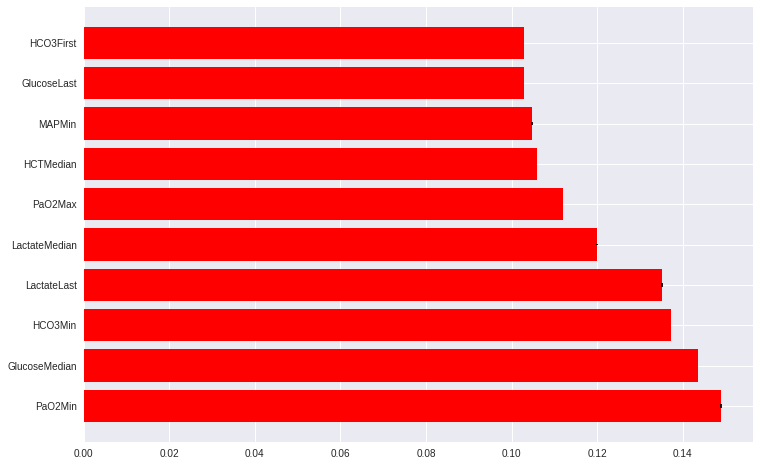

In [83]:
# take mean degradation in performance
feat_imp_mu = np.mean(feat_importance, axis=0)
feat_imp_iqr = np.percentile(feat_importance, 75, axis=0) - np.percentile(feat_importance, 25, axis=0)

# sort to get the features which had the most impact
idxSort = np.argsort(feat_imp_mu)

plt.figure(figsize=[12,8])
# note we negate the feature importance - now higher values indicate more important
plt.barh(range(10), -feat_imp_mu[idxSort[0:10]], color='r',
         yerr = feat_imp_iqr[idxSort[0:10]],
        tick_label = X_header[idxSort[0:10]],
        align='center')
plt.show()

Note that we have changed our metric from the AUROC to the logistic loss. All of the top 10 features make sense: lab values are useful in determining patient outcome.

There are other methods for determining feature importance - in fact, some are included in the random forest model object. The only trick is that they are buried within the pipeline that we used earlier.

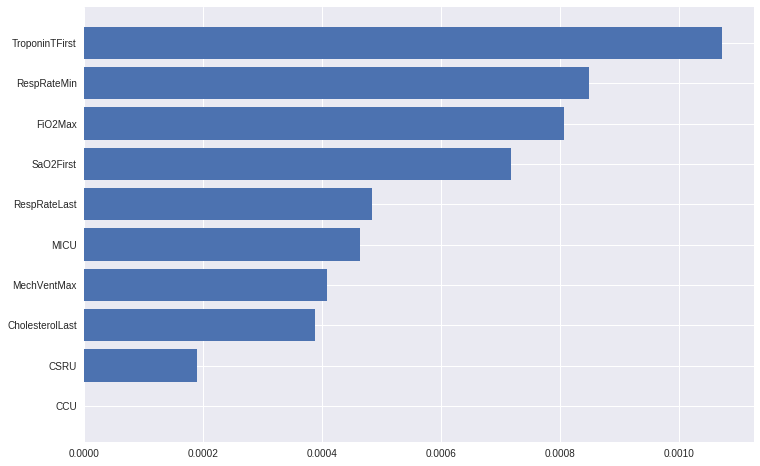

In [84]:
rf_mdl = mdl_pipeline.named_steps['rf']

# get feature importances
feat_imp_rf = rf_mdl.feature_importances_

# same as before - let's plot it!
idxSort = np.argsort(feat_imp_rf)

plt.figure(figsize=[12,8])
plt.barh(range(10), feat_imp_rf[idxSort[0:10]],
        tick_label = X_header[idxSort[0:10]],
        align='center')
plt.show()

Here we get very different feature importances. Why is this? It helps to understand how these feature importances are derived.

The first feature importance was done based on overall performance: potassium ended up being very useful across all patients in predicting mortality.

Alternatively, the second method is based on the Gini importance. Remember that a random forest is made up of many trees. This second method says: for each split that uses the feature, how much "purer" are the two subsequent nodes. Below, the percentage is the frequency of the outcome, where we start with 50% (equal number of both groups in that node).
```
50%
|
| split on feature here
|\
| \
|  \
|   \
|    \
25%  75%
```
Above, after we split on the feature, our nodes are "purer". That is, the left node has more negative outcomes (0s), and the right node as more positive outcomes (1s).

From this, we can conclude that service_traum (Trauma service) is very useful for separating those who survive from those who die. This makes sense: trauma is very bad! Patients who are admitted for trauma are very severely ill, and it is an effective indicator of illness. However, not all patients are trauma patients. Across all patients, potassium is a more important measure in indicating illness.

### Cross-validation
Finally, let's review a very effective technique for estimating how well our classifier is doing: cross-validation. Recall that we split the dataset into two sets: training and test, specifically 80% training and 20% test. As we tested using a smaller dataset (only 20% of the total records), we likely will end up with a noisier estimate of performance than if we used the entire dataset. Of course we can't use the entire dataset because then our model results aren't believable. Cross-validation is a clever way to use the entire dataset and use held-out data for proper evaluation. Each observation is assigned to a group. Let's say we have K groups. We then can build a model using data in the kth group as the test set, and all other data as the training set. Let's take a look at some code.




In [85]:
# create the K fold indices
K = 5

idxK = np.random.permutation(X.shape[0])
idxK = np.mod(idxK,K)

print('First 10 observations:',end=' ')
print(idxK[0:10])
print('idxK shape:',end=' ')
print(idxK.shape)

First 10 observations: [4 2 0 1 1 2 4 4 2 1]
idxK shape: (4000,)


Above you can see we have generated an integer, up to K-1 (but including 0), for all observations in the training set. We will now iterate through the unique integers to "hold out" a subset of the data for each model training.

In [86]:
xval_auc = list()

for k in range(K):
    idxTest = idxK == k
    idxTrain = idxK != k

    X_train = X[idxTrain, :]
    y_train = y[idxTrain]
    X_test = X[idxTest, :]
    y_test = y[idxTest]
    
    # train the model using all but the kth fold
    curr_mdl = estimator.fit(X_train, y_train)
    
    # evaluate using the kth fold
    yhat = curr_mdl.predict_proba(X_test)[:,1]
    curr_score = metrics.roc_auc_score(y_test, yhat)
    xval_auc.append( curr_score )
    

    print('{} - Finished fold {} of {}. AUROC {:0.3f}.'.format(dt.datetime.now(),
                                                               k+1, K, curr_score))

2018-05-23 18:04:04.675758 - Finished fold 1 of 5. AUROC 0.808.
2018-05-23 18:04:04.914587 - Finished fold 2 of 5. AUROC 0.782.
2018-05-23 18:04:05.184512 - Finished fold 3 of 5. AUROC 0.775.
2018-05-23 18:04:05.455752 - Finished fold 4 of 5. AUROC 0.778.
2018-05-23 18:04:05.721222 - Finished fold 5 of 5. AUROC 0.794.


### Hyperparameter optimization
Let's look at our estimator.

In [87]:
estimator = Pipeline([
        ("imputer", Imputer(missing_values='NaN',
                                  strategy="mean",
                                  axis=0)),
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier())
    ])

print(estimator.named_steps['rf'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


Careful observation will note a few parameters which we could play around with:

* criterion - what method to evaluate how well a node is splitting the data
* max_depth - a limit on how deep the tree is
* max_features - how many to look at for an inidividual tree
* max_leaf_nodes - maximum number of leaf or end nodes
* min_impurity_split - minimum impurity to allow for a split (the criterion is impurity)
* min_samples_leaf - minimum samples in a leaf node
* min_samples_split - minimum samples required to split a node
* min_weight_fraction_leaf - similar to min_samples_leaf, except sometimes we are using weighted data, and so this takes that into account
* n_estimators - the number of trees to learn

You'll note that all of these parameters have values - but who is to say these values are optimal? They have been set to sensible defaults - all of which perform well on a variety of problems - but there's no reason that they would perform best on our problem! What we need to do is *hyperparameter optimization*: the above are "hyperparameters" (i.e., they are not the parameters the model uses to make decisions, but they are used to configure the model itself). We can optimize these in a few ways, but the simplest to understand is grid search. Grid search is essentially a brute force method of trying a bunch of combinations and picking the one that does best.

Happily, scikit-learn provides some tools to do grid search using cross-validation, which is exactly what we want to do.

In [88]:
params = {'rf__max_depth': [10],
         'rf__n_estimators': [10,50]}

estimator = Pipeline([
        ("imputer", Imputer(missing_values='NaN',
                                  strategy="mean",
                                  axis=0)),
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier())
    ])

curr_mdl = model_selection.GridSearchCV(estimator, params,
                   scoring='roc_auc',
                   verbose=2, refit=True)
curr_mdl.fit(X, y)

#curr_mdl.cv_results_['mean_test_score']

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] rf__max_depth=10, rf__n_estimators=10 ...........................
[CV] ............ rf__max_depth=10, rf__n_estimators=10, total=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] rf__max_depth=10, rf__n_estimators=10 ...........................
[CV] ............ rf__max_depth=10, rf__n_estimators=10, total=   0.2s
[CV] rf__max_depth=10, rf__n_estimators=10 ...........................
[CV] ............ rf__max_depth=10, rf__n_estimators=10, total=   0.2s
[CV] rf__max_depth=10, rf__n_estimators=50 ...........................
[CV] ............ rf__max_depth=10, rf__n_estimators=50, total=   0.7s
[CV] rf__max_depth=10, rf__n_estimators=50 ...........................
[CV] ............ rf__max_depth=10, rf__n_estimators=50, total=   0.7s
[CV] rf__max_depth=10, rf__n_estimators=50 ...........................
[CV] ............ rf__max_depth=10, rf__n_estimators=50, total=   0.6s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rf__max_depth': [10], 'rf__n_estimators': [10, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [89]:
for x in curr_mdl.cv_results_:
    print(x,end=': ')
    print(curr_mdl.cv_results_[x])

mean_fit_time: [0.15003959 0.63994606]
std_fit_time: [0.00779893 0.04507971]
mean_score_time: [0.01113184 0.01891518]
std_score_time: [0.001974   0.00057842]
param_rf__max_depth: [10 10]
param_rf__n_estimators: [10 50]
params: [{'rf__max_depth': 10, 'rf__n_estimators': 10}, {'rf__max_depth': 10, 'rf__n_estimators': 50}]
split0_test_score: [0.78784137 0.82479712]
split1_test_score: [0.80887728 0.83174558]
split2_test_score: [0.80733743 0.82914994]
mean_test_score: [0.80134903 0.82856392]
std_test_score: [0.0095756  0.00286746]
rank_test_score: [2 1]
split0_train_score: [0.97408721 0.99583998]
split1_train_score: [0.98723857 0.9967213 ]
split2_train_score: [0.98241185 0.99635523]
mean_train_score: [0.98124588 0.99630551]
std_train_score: [0.00543195 0.00036151]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py

### More models!
We are now armed with the ability to train and effectively evaluate our models. Now the fun begins. Let's evaluate a few different models to see which one does best.



In [90]:
# Rough timing info:
#     rf - 3 seconds per fold
# logreg - 4 seconds per fold
#  lasso - 8 seconds per fold
models = {'l1': LogisticRegression(penalty='l1', multi_class='ovr', n_jobs=-1),
          'l2': LogisticRegression(penalty='l2', multi_class='ovr', n_jobs=-1), 
          'nb': MultinomialNB(), 
          'svc': CalibratedClassifierCV(base_estimator=LinearSVC(penalty='l2', loss='squared_hinge', C=1.0, multi_class='ovr', random_state=0, max_iter=1000), cv=5), 
          'rbf': SVC(kernel='rbf', probability=True, decision_function_shape='ovr'), 
          'rf': RandomForestClassifier(n_estimators=100, n_jobs=-1), 
          'adab': AdaBoostClassifier(n_estimators=100), 
          'gb': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
          'mlp':MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(128, 64, 32), random_state=42)
         }       
                
# create k-fold indices
K = 5 # number of folds
idxK = np.random.permutation(X.shape[0])
idxK = np.mod(idxK,K)

mdl_val = dict()
results_val = dict()
pred_val = dict()
tar_val = dict()

for mdl in models:
    print('=============== {} ==============='.format(mdl))
    mdl_val[mdl] = list()
    results_val[mdl] = list() # initialize list for scores
    pred_val[mdl] = list()
    tar_val[mdl] = list()

    if mdl == 'xgb':
        # no pre-processing of data necessary for xgb
        estimator = Pipeline([(mdl, models[mdl])])

    else:
        estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                          strategy="mean",
                                          axis=0)),
                      ("scaler", StandardScaler()),
                      (mdl, models[mdl])]) 

    for k in range(K):
        # train the model using all but the kth fold
        curr_mdl = estimator.fit(X[idxK != k, :],y[idxK != k])

        # get prediction on this dataset
        if mdl == 'lasso':
            curr_prob = curr_mdl.predict(X[idxK == k, :])
        else:
            curr_prob = curr_mdl.predict_proba(X[idxK == k, :])
            curr_prob = curr_prob[:,1]
        
        pred_val[mdl].append(curr_prob)
        tar_val[mdl].append(y[idxK == k])
        
        # calculate score (AUROC)
        curr_score = metrics.roc_auc_score(y[idxK == k], curr_prob)

        # add score to list of scores
        results_val[mdl].append(curr_score)

        # save the current model
        mdl_val[mdl].append(curr_mdl)
        
        print('{} - Finished fold {} of {}. AUROC {:0.3f}.'.format(dt.datetime.now(), k+1, K, curr_score))
    

NameError: ignored

## More data!

So far we have been using the set of features we were given. They are all sensible features, but they may not capture all of the information in the time series. In the next notebook, we'll show how you can extract a few more features, and build some models of your own.